# Transfer Learning with VGG16

In this notebook, I will go over steps to retrain VGG16 net for the skin cancer dataset.

In [36]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical# convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



import matplotlib.pyplot as plt

## Load in the Dataset

In [ ]:

X_train = np.load(r"C:\Users\sudee\OneDrive\Desktop\ml project\SKIN CANCER\256_192_train.npy")

In [ ]:
y_train = np.load(r"C:\Users\sudee\OneDrive\Desktop\ml project\SKIN CANCER\train_labels.npy")

In [ ]:
X_val = np.load(r"C:\Users\sudee\OneDrive\Desktop\ml project\SKIN CANCER\256_192_val.npy")

In [ ]:
y_val = np.load(r"C:\Users\sudee\OneDrive\Desktop\ml project\SKIN CANCER\val_labels.npy")

## Reshape the Dataset

In [41]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [42]:
y_train.shape, y_val.shape

((8111,), (902,))

In [43]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [44]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load in Pretrained VGG16 Model

In [45]:
pre_trained_model = VGG16(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [46]:
# Assuming pre_trained_model is already defined and built
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

# Print the total number of layers in the pre-trained model
print('Total number of layers:', len(pre_trained_model.layers))

# Get the last layer
last_layer = pre_trained_model.get_layer('block5_pool')

# Access output shape correctly
# Use the layer instance method if necessary
last_layer_output_shape = last_layer.output.shape  # Use .shape to get the tensor shape
print('Last layer output shape:', last_layer_output_shape)

# Alternatively, you can use model.summary() to view output shapes for all layers
pre_trained_model.summary()


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Total number of layers: 19
Last layer output shape: (None, 6, 8, 512)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 24, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 24, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Define the Model

In [47]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
print('Last layer output shape:', last_output.shape)

# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)

# Define the optimizer
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


Last layer output shape: (None, 6, 8, 512)


In [48]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 24, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 24, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

### Feature-Extraction

If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of feature extraction first so that weights of the final fully connected layer aren't completely random. The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large and will change the pretrained weights too much.

In [49]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [50]:
print("X_train:", X_train)
print("y_train:", y_train)
print("X_val:", X_val)
print("y_val:", y_val)


X_train: [[[[0.41568628 0.3647059  0.42352942]
   [0.41960785 0.3647059  0.41960785]
   [0.42352942 0.3764706  0.4392157 ]
   ...
   [0.52156866 0.50980395 0.54901963]
   [0.5294118  0.5058824  0.5529412 ]
   [0.5529412  0.5294118  0.57254905]]

  [[0.42745098 0.36862746 0.4392157 ]
   [0.42352942 0.36862746 0.43529412]
   [0.42745098 0.37254903 0.43529412]
   ...
   [0.5372549  0.53333336 0.5647059 ]
   [0.5529412  0.54509807 0.5764706 ]
   [0.5529412  0.5411765  0.57254905]]

  [[0.42352942 0.37254903 0.43529412]
   [0.42745098 0.3764706  0.44313726]
   [0.42745098 0.3764706  0.43529412]
   ...
   [0.5568628  0.54901963 0.5764706 ]
   [0.5647059  0.5411765  0.5764706 ]
   [0.5568628  0.5411765  0.5764706 ]]

  ...

  [[0.48235294 0.44705883 0.52156866]
   [0.49019608 0.44705883 0.52156866]
   [0.4862745  0.45490196 0.53333336]
   ...
   [0.54509807 0.5137255  0.54901963]
   [0.54509807 0.52156866 0.5529412 ]
   [0.5568628  0.52156866 0.5529412 ]]

  [[0.48235294 0.45490196 0.5254902 

In [51]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [52]:
batch_size = 64
epochs = 3
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1, steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size))


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 714s 6s/step - accuracy: 0.6177 - loss: 1.3330 - val_accuracy: 0.6451 - val_loss: 1.0108
Epoch 2/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 295ms/step - accuracy: 0.6250 - loss: 1.0599 - val_accuracy: 0.6406 - val_loss: 1.0289
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 668s 5s/step - accuracy: 0.6765 - loss: 0.9549 - val_accuracy: 0.8333 - val_loss: 0.4747


### Fine Tuning Model

Let's fine tune the last convolutional block of VGG net. I only use learning_rate = 0.0001 with very high momentum = 0.9 and train for 35 epochs only so that the original weights of pretrained VGG net won't be changed too much. learning_rate_reduction function is used and will halve the learning_rate whenever the validation accuracy plateaus for 3 epochs. 

In [53]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [54]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None,amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 24, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 24, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 7,345,671 (28.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

By setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters

In [56]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [57]:
X_train.shape

(8111, 192, 256, 3)

In [58]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [59]:
batch_size = 64
epochs = 30
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 815s 6s/step - accuracy: 0.6367 - loss: 1.3900 - val_accuracy: 0.6652 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.7188 - loss: 0.8649 - val_accuracy: 0.6451 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 775s 6s/step - accuracy: 0.6722 - loss: 0.9839 - val_accuracy: 1.0000 - val_loss: 0.1908 - learning_rate: 0.0010
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 300ms/step - accuracy: 0.6094 - loss: 1.0402 - val_accuracy: 0.6496 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 813s 6s/step - accuracy: 0.6876 - loss: 0.9658 - val_accuracy: 0.6763 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 6/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 12:36 6s/step - accuracy: 0.7500 - loss: 0.7051
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7500 - loss:

In [60]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7877 - loss: 0.6297
Validation: accuracy = 0.763858  ;  loss_v = 0.654424


Our model clearly overfits the training dataset. But we do observe some improvement with validation accuracy, which is clearly better than the baseline model! Having around 3% improvement from the baseline model justifies some more training time. This improvement proves that weights of pretrained model learned from ImageNet generalize to our dataset, which is completely different from ImageNet. 

## Testing

In [ ]:
X_test = np.load(r"C:\Users\sudee\OneDrive\Desktop\ml project\SKIN CANCER\256_192_test.npy")

In [ ]:
y_test = np.load(r"C:\Users\sudee\OneDrive\Desktop\ml project\SKIN CANCER\test_labels.npy")
y_test = to_categorical(y_test)

In [63]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7505 - loss: 0.6544
Test: accuracy = 0.764471  ;  loss = 0.640598


In [65]:
model.save("VGG16.keras")

Text(0.5, 1.0, 'Training and validation loss')

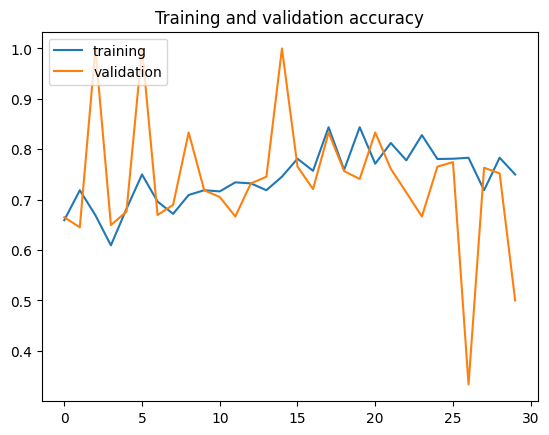

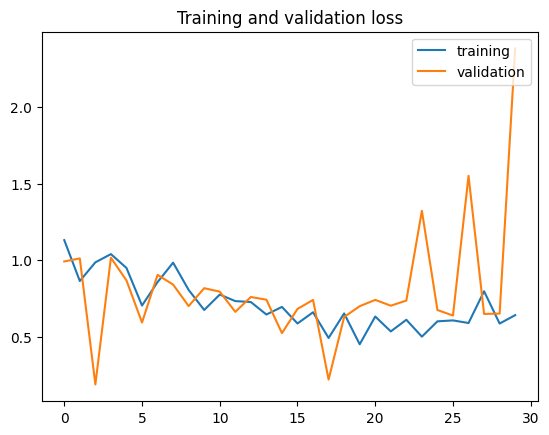

In [67]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')